# Style Embeddings Visualisation
This notebook visualises the style embeddings. Specifically, we can visualize 1) proportion $p$ of the ith relevant factor and 2) latent style vector $z_1$. (it's $z_2$ in the code as the codebase used $z_2$). 

In [42]:
import os
import torch
from utils.text_utils import MonoTextData
import numpy as np
import config
from models.decomposed_vae import DecomposedVAE
from itertools import chain
import umap
import matplotlib.pyplot as plt

### Options

In [2]:
class Args:
    data_name = "gyafc"
    hard_disk_dir = "/hdd2/lannliat/CP-VAE"
    load_path = "/hdd2/lannliat/CP-VAE/checkpoint/ours-valfixed-gyafc-glove/20220831-082802"
    feat = "glove"
    text_only = False
args = Args()

### Loading Data

In [11]:
conf = config.CONFIG[args.data_name]
data_pth = os.path.join(args.hard_disk_dir, "data", args.data_name, "processed")
train_data_pth = os.path.join(data_pth, "train_data.txt")
train_feat_pth = os.path.join(data_pth, "train_%s.npy" % args.feat)
train_data = MonoTextData(train_data_pth, True)
train_feat = np.load(train_feat_pth)
vocab = train_data.vocab
dev_data_pth = os.path.join(data_pth, "dev_data.txt")
dev_feat_pth = os.path.join(data_pth, "dev_%s.npy" % args.feat)
dev_data = MonoTextData(dev_data_pth, True, vocab=vocab)
dev_feat = np.load(dev_feat_pth)
test_data_pth = os.path.join(data_pth, "test_data.txt")
test_feat_pth = os.path.join(data_pth, "test_%s.npy" % args.feat)
test_data = MonoTextData(test_data_pth, True, vocab=vocab)
test_feat = np.load(test_feat_pth)

### Loading model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {
        "train": ([1], None),
        "valid": (None, None),
        "test": (None, None),
        "feat": None,
        "bsz": 32,
        "save_path": args.load_path,
        "logging": None,
        "text_only": args.text_only,
        "writer": None
    }
params = conf["params"]
params["vae_params"]["vocab"] = vocab
params["vae_params"]["device"] = device
params["vae_params"]["text_only"] = args.text_only
params["vae_params"]["mlp_ni"] = dev_feat.shape[1]
kwargs = dict(kwargs, **params)

model = DecomposedVAE(**kwargs)
model.load(args.load_path)
model.vae.eval()

DecomposedVAE(
  (lstm_encoder): LSTMEncoder(
    (embed): Embedding(32689, 256)
    (lstm): LSTM(256, 1024, num_layers=2, bidirectional=True)
    (linear): Linear(in_features=1024, out_features=128, bias=False)
  )
  (mlp_encoder): SemMLPEncoder(
    (output): Linear(in_features=300, out_features=32, bias=True)
    (var_linear): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): LSTMDecoder(
    (embed): Embedding(32689, 128, padding_idx=32688)
    (dropout_in): Dropout(p=0.5, inplace=False)
    (dropout_out): Dropout(p=0.5, inplace=False)
    (trans_linear): Linear(in_features=80, out_features=1024, bias=False)
    (lstm): LSTM(208, 1024)
    (pred_linear): Linear(in_features=1024, out_features=32689, bias=False)
  )
)

### Getting latent style vectors

In [66]:
# plotting latent semantic vectors z2
train_data_list, train_labels_list = train_data.create_data_batch_labels(32, device)
_, train_feat_list = train_data.create_data_batch_feats(32, train_feat, device)
z2_accum = []
for batch_feat in train_feat_list:
    z2, _ = model.vae.encode_semantic(batch_feat)
    z2_accum.append(z2)
emb = torch.cat(z2_accum, dim=1).squeeze().cpu().detach().numpy()
labels = list(chain.from_iterable(train_labels_list))

Maximum length: 50


In [ ]:
# plotting proportion p
train_data_list, train_labels_list = train_data.create_data_batch_labels(32, device)
_, train_feat_list = train_data.create_data_batch_feats(32, train_feat, device)
p_accum = []
for batch_feat in train_feat_list:
    r, _ = model.vae.mlp_encoder(batch_feat, True) # Wh+b
    p = model.vae.get_var_prob(r) # p in equation 3 (softmax(Wh + b))
    p_accum.append(p)
emb = torch.cat(p_accum, dim=0).squeeze().cpu().detach().numpy()
labels = list(chain.from_iterable(train_labels_list))

**3D scatter plot** 

Useful if simplex is of K=3 (e.g. gyafc)

Text(0.5, 0.92, 'simple 3D scatter plot')

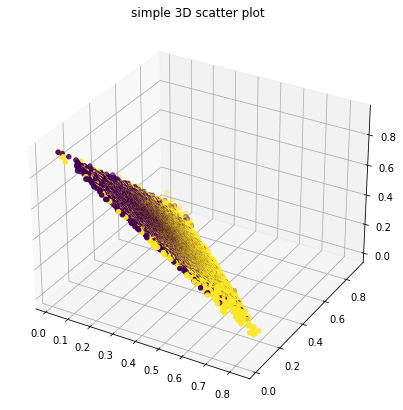

In [74]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(p[:,0], p[:,1], p[:,2], c=labels)
plt.title("simple 3D scatter plot")

**2D scatter plot**

In [36]:
reducer = umap.UMAP()
emb = reducer.fit_transform(emb)

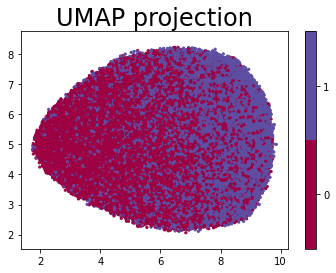

In [46]:
plt.scatter(emb[:, 0], emb[:, 1], c=labels, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection', fontsize=24);

### UMAP tutorial
https://umap.scikit-tda.org/basic_usage.html

In [2]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [3]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [4]:
iris = load_iris()

In [7]:
iris.data.shape

(150, 4)

In [8]:
iris.data[0]

array([5.1, 3.5, 1.4, 0.2])